In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D

from tensorflow.keras.models import load_model

2024-08-09 05:29:18.719650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 05:29:18.755525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 05:29:19.468527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

# #Run this cell if you want to delete existing folder with the same name

# dir_path = 'EFlow Images/data' #Path of the directory to delete

# # Check if the directory exists
# if os.path.exists(dir_path) and os.path.isdir(dir_path):
#     # Delete the directory and all its contents
#     shutil.rmtree(dir_path)
#     print(f'Directory {dir_path} has been deleted.')
# else:
#     print(f'Directory {dir_path} does not exist.')


Directory EFlow Images/data has been deleted.


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-08-07 03:51:35.250094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 03:51:36.354958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 03:51:36.355183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
seed = 42
tf.random.set_seed(seed)

# 0. Extracting the zip files

In [5]:

# folder_path = 'EFlow Images'


# #Extracting the zip files
# parent_data_path = 'EFlow Images/data' #Creating new directory for extracting the images

# for zipName in os.listdir(folder_path):
#     zip_path = os.path.join(folder_path, zipName)
    
#     if zipName[-4:] != '.zip':
#         continue
    
#     print(f'Extracting: {zipName}...')

#     extract_path = os.path.join(parent_data_path, zipName[:-4])
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         for member in zip_ref.namelist():
#             if member.endswith('.png'):
#                 #print(member)
#                 zip_ref.extract(member, extract_path)
    
#     print(f'----Extraction of {zipName} Completed----\n')
#     print(100*'~')


# 1. Data Loading

Found 19675 files belonging to 2 classes.


2024-08-07 03:52:00.222578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 03:52:00.222837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 03:52:00.222977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

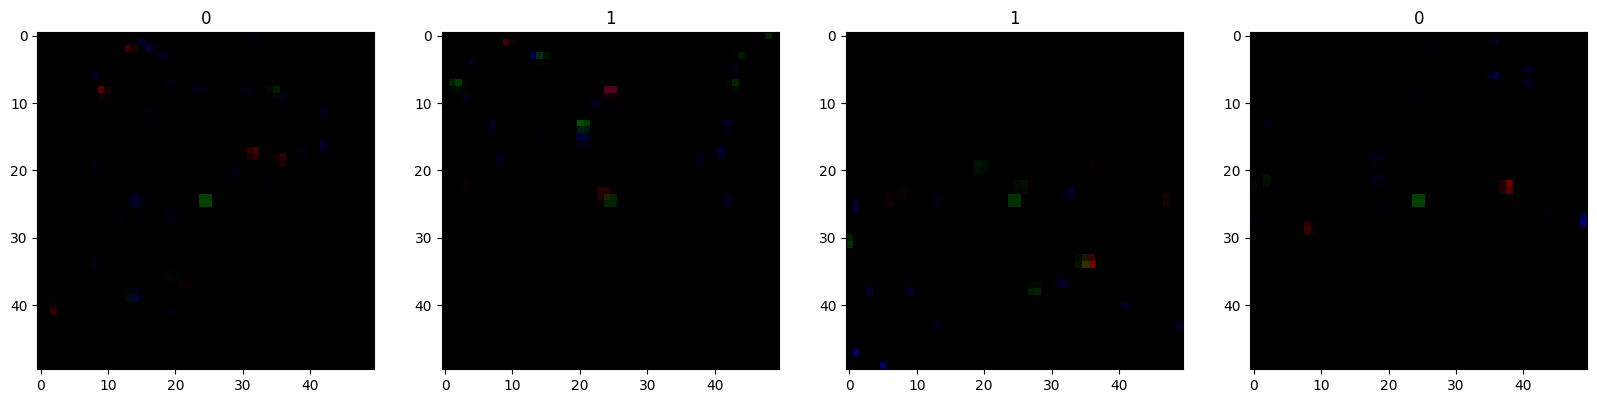

In [5]:
data_dir = 'EFlow Images/data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 200,
                                                   image_size = (50,50))

scaled_data = data.map(lambda x, y: (x/255, y))

data_iterator = scaled_data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 2. Data Splitting

In [6]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [17]:
len(test)

9

# 3. CNN Model 1

In [18]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D()) #2x2 filter

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,761 (295.94 KB)

 Trainable params: 75,761 (295.94 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Training

In [19]:
logdir = 'EFlow Images/logs1'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train,
                 epochs = 20,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/20
 1/69 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.5200 - auc_1: 0.5084 - false_negatives_1: 95.0000 - false_positives_1: 1.0000 - loss: 1.1820 - precision_1: 0.8000 - recall_1: 0.0404 - true_negatives_1: 100.0000 - true_positives_1: 4.0000

I0000 00:00:1722430105.814894    4756 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5288 - auc_1: 0.5319 - false_negatives_1: 1845.2715 - false_positives_1: 1436.7715 - loss: 0.8970 - precision_1: 0.5367 - recall_1: 0.4810 - true_negatives_1: 2133.6287 - true_positives_1: 1681.4714 - val_accuracy: 0.5713 - val_auc_1: 0.6185 - val_false_negatives_1: 693.0000 - val_false_positives_1: 936.0000 - val_loss: 0.6674 - val_precision_1: 0.5710 - val_recall_1: 0.6426 - val_true_negatives_1: 925.0000 - val_true_positives_1: 1246.0000
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6119 - auc_1: 0.6457 - false_negatives_1: 1776.5143 - false_positives_1: 956.6714 - loss: 0.6525 - precision_1: 0.6377 - recall_1: 0.5144 - true_negatives_1: 2622.4285 - true_positives_1: 1741.5286 - val_accuracy: 0.6192 - val_auc_1: 0.6725 - val_false_negatives_1: 966.0000 - val_false_positives_1: 481.0000 - val_loss: 0.6376 - val_precision_1: 0.6739 - val_recall_1: 0.5071 - val_true_negatives_1: 1359.0000 - val_true_positives_1: 9

In [21]:
model.save(os.path.join('EFlow Images','Eflowimageclassifier1.keras'))

# 5. Performance Metrices

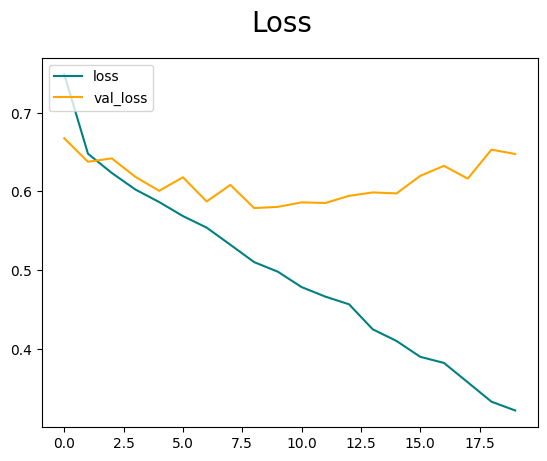

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

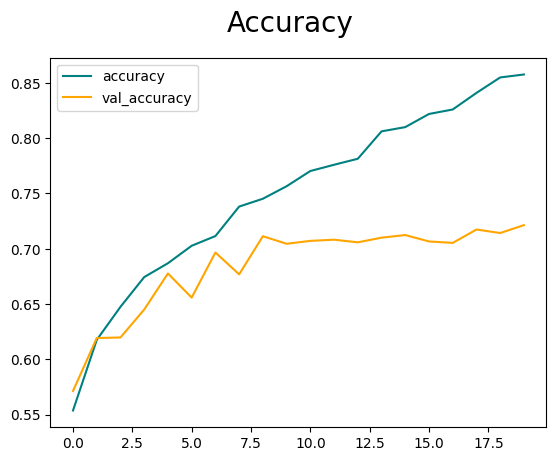

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

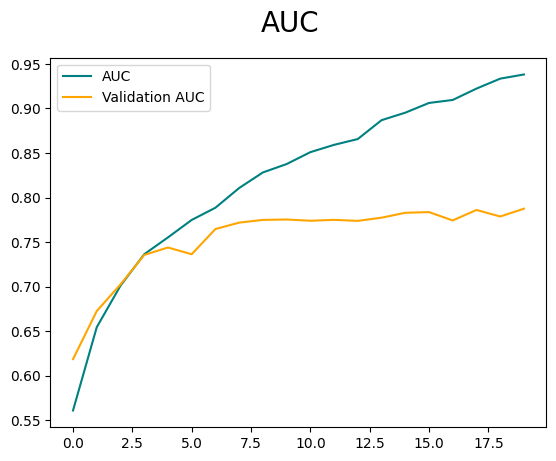

In [25]:
fig = plt.figure()
plt.plot(hist.history['auc_1'], color='teal', label='AUC')
plt.plot(hist.history['val_auc_1'], color='orange', label='Validation AUC')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()


# 6. Testing

In [26]:
test_data = test.as_numpy_iterator()
test_batch = test_data.next()

In [26]:
test_evaluate = model.evaluate(test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6959 - auc_1: 0.7474 - false_negatives_1: 169.2000 - false_positives_1: 160.6000 - loss: 0.7254 - precision_1: 0.6839 - recall_1: 0.6849 - true_negatives_1: 388.8000 - true_positives_1: 361.4000


# Model 2: With 2 additional Convolution Layers

In [8]:
model2 = Sequential()

model2.add(Conv2D(128, (3,3), 1, activation='relu', input_shape=(50,50,3)))
model2.add(MaxPooling2D(strides=1)) #2x2 filter

model2.add(Conv2D(64, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D(strides=1,
                        padding='same'))

model2.add(Conv2D(16, (2,2), 1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(8, (2,2), 1, activation='relu'))
#model2.add(MaxPooling2D())

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [9]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,009 (898.47 KB)

 Trainable params: 230,009 (898.47 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model2.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

## Model 2: Training

In [11]:
logdir = 'EFlow Images/logs2'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist2 = model2.fit(train,
                 epochs = 20,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/20


I0000 00:00:1722430290.610786    7846 service.cc:145] XLA service 0x7f7d7400fc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722430290.610838    7846 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-31 12:51:30.701808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 12:51:30.981915: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
2024-07-31 12:51:31.393152: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 63.46MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-31 12:51:31.445970: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_7406/1951246320.py", line 5, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bw-input.7 = (f32[200,128,47,47]{3,2,1,0}, u8[0]{0}) custom-call(f32[200,64,45,45]{3,2,1,0} %select.49, f32[64,128,3,3]{3,2,1,0} %transpose.144), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/sequential_1/conv2d_1_2/convolution/Conv2DBackpropInput" source_file="/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 242978816 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_4506]

In [14]:
#Saving the model
model2.save(os.path.join('EFlow Images','Eflowimageclassifier2.keras'))

## Model 2: Performance Metrices

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

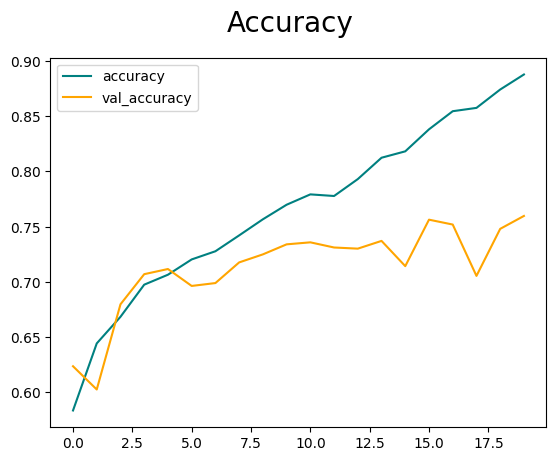

In [19]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

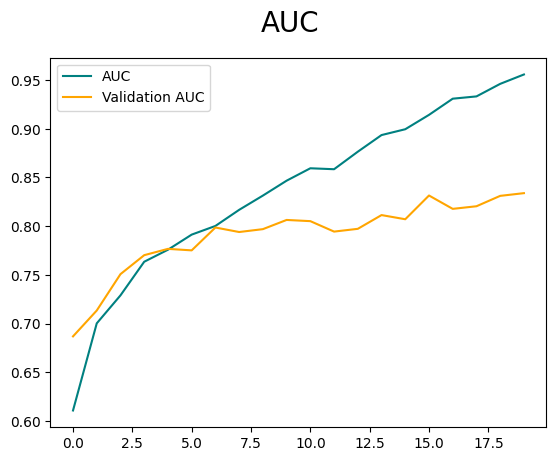

In [20]:
fig = plt.figure()
plt.plot(hist2.history['auc'], color='teal', label='AUC')
plt.plot(hist2.history['val_auc'], color='orange', label='Validation AUC')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
print(f"Best Obtained Loss: {hist2.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist2.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist2.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.269829124212265
Best Obtained Accuracy: 88.78%
Best Obtained Validation Accuracy: 75.97%


## Model 2: Testing

In [38]:
test_evaluate_model2 = model2.evaluate(test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7206 - auc: 0.7946 - false_negatives: 188.1667 - false_positives: 132.3333 - loss: 0.6901 - precision: 0.7648 - recall: 0.6843 - true_negatives: 425.8333 - true_positives: 420.3333


**NOT so Significant increase in the Accuracy by increasing the number of layers**

In [13]:
model2 = load_model('EFlow Images/Eflowimageclassifier2.keras')

In [59]:
y_pred = model2.predict(test).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 


In [60]:
y_pred.shape

(1750,)

In [20]:
threshold = np.arange(0.0, 1.1, 0.1)

In [ ]:
(accuracy, precision, recall, f1) = rocPlot(model = model2, thresholds = threshold, test_data = test)

In [67]:
# Extract all labels from the batches
all_labels = []

for images, labels in data:
    all_labels.extend(labels)

# Convert to a NumPy array if needed
y_true = np.array(all_labels)

2024-07-28 06:32:46.886225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [72]:
y_test_true = y_true[-1750:]

In [73]:
y_test_true.shape

(1750,)

# Model 3: With AveragePooling

In [11]:
model3 = Sequential()

model3.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
model3.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model3.add(Conv2D(64, (3,3), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Conv2D(32, (3,3), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model3.add(Conv2D(16, (2,2), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Conv2D(8, (2,2), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [12]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 49, 49, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 23, 23, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 21, 21, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 10, 10, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 4, 4, 8)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,689 (1.03 MB)

 Trainable params: 269,689 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model3.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [14]:
logdir = 'EFlow Images/logs3'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist3 = model3.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


I0000 00:00:1722429926.010367    4756 service.cc:145] XLA service 0x7f4de00117a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722429926.010420    4756 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-31 12:45:26.113948: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 12:45:26.421054: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
2024-07-31 12:45:26.833475: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 443.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-31 12:45:26.842906: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_3086/4264782636.py", line 5, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.15 = (f32[350,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[350,3,50,50]{3,2,1,0} %transpose.142, f32[128,3,5,5]{3,2,1,0} %transpose.143, f32[128]{0} %arg3.4), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 464777216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_4817]

In [15]:
print(f"Best Obtained Loss: {hist3.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist3.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist3.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.36685389280319214
Best Obtained Accuracy: 83.35%
Best Obtained Validation Accuracy: 76.23%


In [17]:
#Saving the model
#model3.save(os.path.join('EFlow Images','Eflowimageclassifier3.keras'))

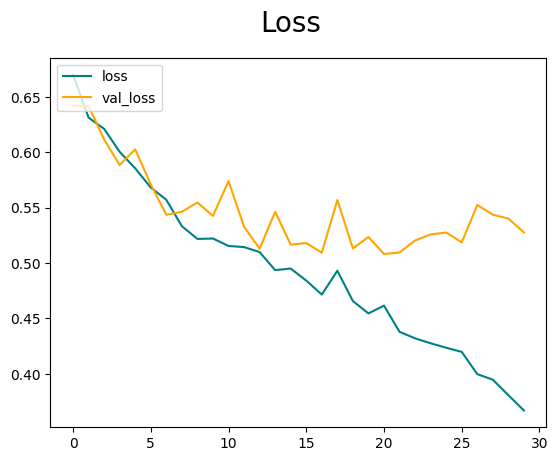

In [21]:
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

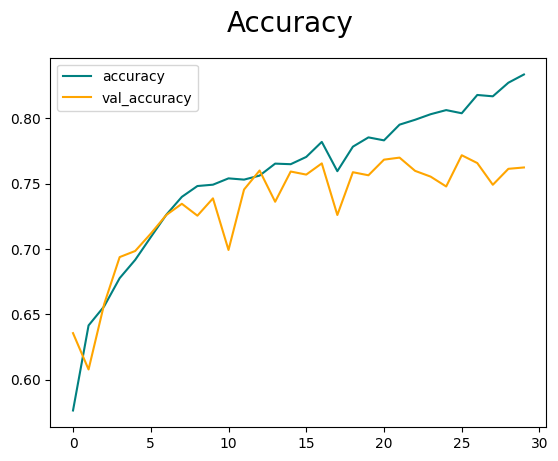

In [22]:
fig = plt.figure()
plt.plot(hist3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

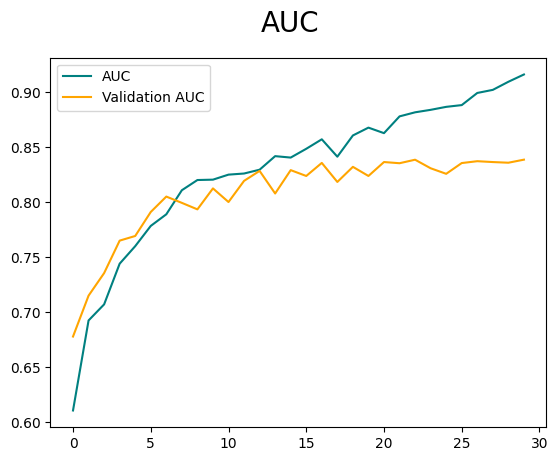

In [20]:
fig = plt.figure()
plt.plot(hist3.history['auc'], color='teal', label='AUC')
plt.plot(hist3.history['val_auc'], color='orange', label='Validation AUC')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
test_evaluate_model3 = model3.evaluate(test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7442 - auc: 0.8253 - false_negatives: 176.0000 - false_positives: 120.0000 - loss: 0.5735 - precision: 0.7695 - recall: 0.7027 - true_negatives: 461.6667 - true_positives: 409.0000


# Model 4: Leaky ReLU

In [10]:
model_Leaky_ReLU = Sequential()

model_Leaky_ReLU.add(Conv2D(128, (5,5), 1, padding = 'same', activation='leaky_relu', input_shape=(50,50,3)))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model_Leaky_ReLU.add(Conv2D(64, (3,3), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2)))

model_Leaky_ReLU.add(Conv2D(32, (3,3), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model_Leaky_ReLU.add(Conv2D(16, (2,2), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2)))

model_Leaky_ReLU.add(Conv2D(8, (2,2), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2)))

model_Leaky_ReLU.add(Flatten())

model_Leaky_ReLU.add(Dense(256, activation='leaky_relu'))
model_Leaky_ReLU.add(Dense(512, activation='leaky_relu'))
model_Leaky_ReLU.add(Dense(1, activation='sigmoid'))

In [11]:
model_Leaky_ReLU.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [12]:
logdir = 'EFlow Images/logsLeakyReLU'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

histLeaky_ReLU = model_Leaky_ReLU.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


I0000 00:00:1723002842.988624    2614 service.cc:145] XLA service 0x7f6830012030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723002842.988840    2614 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-07 03:54:03.110977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-07 03:54:03.520479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1723002854.053889    2614 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5523 - auc_1: 0.5734 - false_negatives_1: 1988.1857 - false_positives_1: 1092.4286 - loss: 0.6819 - precision_1: 0.5694 - recall_1: 0.4527 - true_negatives_1: 2477.9714 - true_positives_1: 1538.5571 - val_accuracy: 0.6339 - val_auc_1: 0.7064 - val_false_negatives_1: 1069.0000 - val_false_positives_1: 322.0000 - val_loss: 0.6475 - val_precision_1: 0.7299 - val_recall_1: 0.4487 - val_true_negatives_1: 1539.0000 - val_true_positives_1: 870.0000
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6411 - auc_1: 0.7002 - false_negatives_1: 1511.7285 - false_positives_1: 988.9714 - loss: 0.6296 - precision_1: 0.6627 - recall_1: 0.5684 - true_negatives_1: 2590.1287 - true_positives_1: 2006.3143 - val_accuracy: 0.7016 - val_auc_1: 0.7663 - val_false_negatives_1: 669.0000 - val_false_positives_1: 465.0000 - val_loss: 0.5841 - val_precision_1: 0.7352 - val_recall_1: 0.6587 - val_true_negatives_1: 1375.0000 - val_true_positives_1:

In [14]:
print(f"Best Obtained Loss: {histLeaky_ReLU.history['loss'][-1]}\n\
Best Obtained Accuracy: {histLeaky_ReLU.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {histLeaky_ReLU.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.3626191020011902
Best Obtained Accuracy: 83.42%
Best Obtained Validation Accuracy: 72.63%


In [15]:
#Saving the model
model3.save(os.path.join('EFlow Images','Eflowimageclassifier_Leaky_ReLU.keras'))

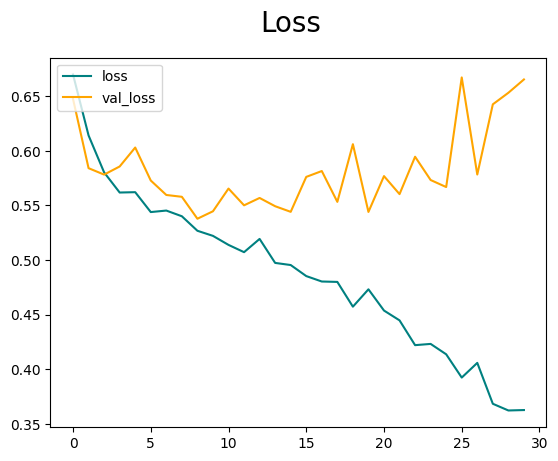

In [16]:
fig = plt.figure()
plt.plot(histLeaky_ReLU.history['loss'], color='teal', label='loss')
plt.plot(histLeaky_ReLU.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

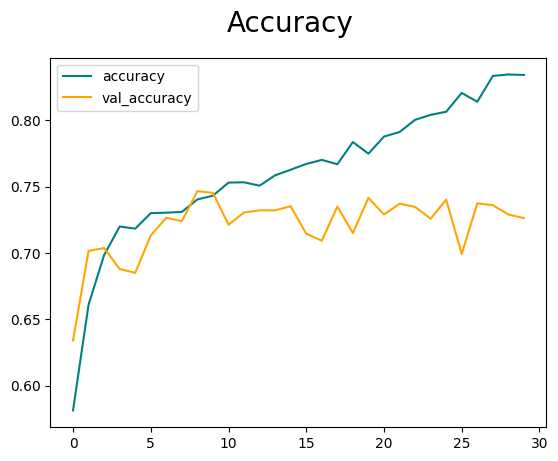

In [17]:
fig = plt.figure()
plt.plot(histLeaky_ReLU.history['accuracy'], color='teal', label='accuracy')
plt.plot(histLeaky_ReLU.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

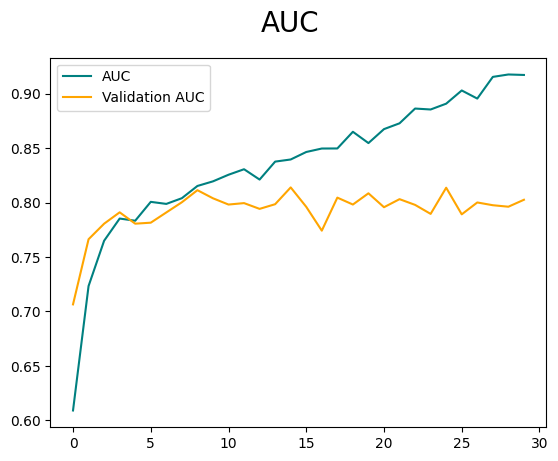

In [19]:
fig = plt.figure()
plt.plot(histLeaky_ReLU.history['auc_1'], color='teal', label='AUC')
plt.plot(histLeaky_ReLU.history['val_auc_1'], color='orange', label='Validation AUC')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()